In [1]:
import math

# -------------------------
# 已知参数 (单位：µm)
# -------------------------
D0 = 20.0    # 初始锡滴直径
D_top = 40.0  # 圆台上直径
D_bot = 350.0 # 圆台下直径

# -------------------------
# 1. 球体体积
# -------------------------
V_sphere = math.pi / 6 * D0**3

# -------------------------
# 2. 圆台体积公式
# -------------------------
def frustum_volume(h, D1, D2):
    return math.pi * h / 12.0 * (D1**2 + D1*D2 + D2**2)

# 解析解（令体积相等，解 h）
h_closed = 2 * D0**3 / (D_top**2 + D_top*D_bot + D_bot**2)

# -------------------------
# 3. 数值积分计算
# -------------------------
def frustum_volume_by_sum(h, dh):
    """
    用中点法数值积分计算圆台体积
    h : 厚度 (µm)
    dh: 步长 (µm)
    """
    R_top = D_top / 2.0
    R_bot = D_bot / 2.0
    n_steps = max(1, int(math.ceil(h / dh)))
    dz = h / n_steps
    vol = 0.0
    for i in range(n_steps):
        z = (i + 0.5) * dz
        r = R_top + (R_bot - R_top) * (z / h)  # 半径线性插值
        vol += math.pi * r * r * dz
    return vol

def find_h_by_bisection(dh, tol=1e-9, h_min=1e-6, h_max=10.0):
    """
    用二分法找出使得数值积分体积 ≈ 球体体积的厚度 h
    """
    while frustum_volume_by_sum(h_max, dh) < V_sphere:
        h_max *= 2.0
        if h_max > 1e6:
            raise RuntimeError("搜索范围过大")
    lo, hi = h_min, h_max
    for _ in range(100):
        mid = 0.5 * (lo + hi)
        vmid = frustum_volume_by_sum(mid, dh)
        if abs(vmid - V_sphere) / V_sphere < tol:
            return mid
        if vmid > V_sphere:
            hi = mid
        else:
            lo = mid
    return 0.5 * (lo + hi)

# -------------------------
# 4. 运行并输出结果
# -------------------------
print("球体体积 V_sphere = {:.6f} µm³".format(V_sphere))
print("解析解厚度 h = {:.12f} µm = {:.6f} nm".format(h_closed, h_closed*1000))

step_sizes = [1e-1, 1e-2, 1e-3, 5e-4, 1e-4]  # µm
print("\n数值积分结果 (中点法 + 二分法)：")
for dh in step_sizes:
    h_num = find_h_by_bisection(dh)
    print("  dh = {:6.1e} µm -> h = {:.12f} µm = {:.6f} nm".format(dh, h_num, h_num*1000))

# 验证体积相等性
V_check = frustum_volume(h_closed, D_top, D_bot)
print("\n解析解体积与球体体积差值 = {:.3e}".format(V_check - V_sphere))


球体体积 V_sphere = 4188.790205 µm³
解析解厚度 h = 0.115858073860 µm = 115.858074 nm

数值积分结果 (中点法 + 二分法)：
  dh = 1.0e-01 µm -> h = 0.121126094122 µm = 121.126094 nm
  dh = 1.0e-02 µm -> h = 0.115998212748 µm = 115.998213 nm
  dh = 1.0e-03 µm -> h = 0.115859571718 µm = 115.859572 nm
  dh = 5.0e-04 µm -> h = 0.115858448310 µm = 115.858448 nm
  dh = 1.0e-04 µm -> h = 0.115858088878 µm = 115.858089 nm

解析解体积与球体体积差值 = 0.000e+00


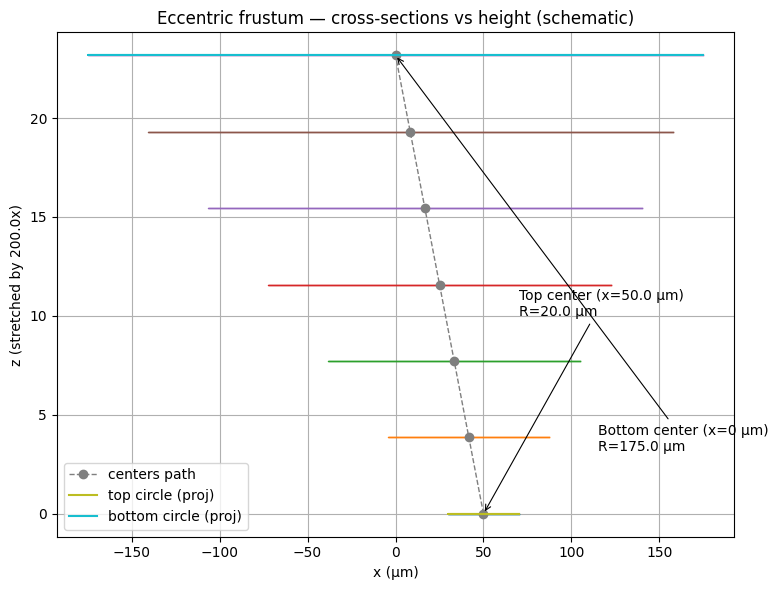

In [2]:
# Retry: plot eccentric frustum cross-sections (x-z schematic).
import math
import numpy as np
import matplotlib.pyplot as plt

# Geometry (µm)
D_top = 40.0
D_bot = 350.0
h = 0.11585807385952208

offset_x = 50.0  # µm offset for visualization
n_slices = 7
R_top = D_top / 2.0
R_bot = D_bot / 2.0

zs = np.linspace(0, h, n_slices)
centers_x = np.linspace(offset_x, 0.0, n_slices)
radii = R_top + (R_bot - R_top) * (zs / h)
theta = np.linspace(0, 2*np.pi, 360)

z_scale = 200.0

fig, ax = plt.subplots(figsize=(8,6))

for i, z in enumerate(zs):
    x_center = centers_x[i]
    r = radii[i]
    x_circle = x_center + r * np.cos(theta)
    ax.plot(x_circle, np.full_like(x_circle, z * z_scale), linewidth=1)

ax.plot(centers_x, zs * z_scale, marker='o', linestyle='--', linewidth=1, label='centers path')

x_top = offset_x + R_top * np.cos(theta)
ax.plot(x_top, np.full_like(x_top, zs[0]*z_scale), linewidth=1.5, label='top circle (proj)')
x_bot = 0.0 + R_bot * np.cos(theta)
ax.plot(x_bot, np.full_like(x_bot, zs[-1]*z_scale), linewidth=1.5, label='bottom circle (proj)')

ax.annotate(f"Top center (x={offset_x:.1f} µm)\nR={R_top:.1f} µm", xy=(offset_x, zs[0]*z_scale), xytext=(offset_x+20, zs[0]*z_scale+10),
            arrowprops=dict(arrowstyle="->", linewidth=0.8))
ax.annotate(f"Bottom center (x=0 µm)\nR={R_bot:.1f} µm", xy=(0.0, zs[-1]*z_scale), xytext=(R_bot-60, zs[-1]*z_scale-20),
            arrowprops=dict(arrowstyle="->", linewidth=0.8))

ax.set_xlabel("x (µm)")
ax.set_ylabel(f"z (stretched by {z_scale}x)")
ax.set_title("Eccentric frustum — cross-sections vs height (schematic)")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/rot_sym_example.png'

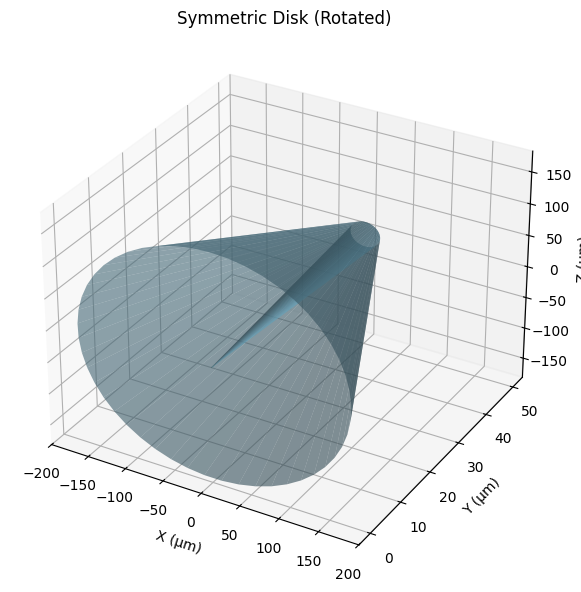

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 修复后的旋转示意图绘制函数
def plot_rotational_schematic(xs, ys, title, filename):
    """
    绘制旋转后的示意图：将给定的剖面 (xs, ys) 绕 y 轴旋转生成的三维形状投影。
    """
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')

    # 创建旋转
    theta = np.linspace(0, 2*np.pi, 50)
    Xs, Thetas = np.meshgrid(xs, theta)
    Ys = np.tile(ys, (50,1))
    Zs = Xs * np.cos(Thetas)
    Xproj = Xs * np.sin(Thetas)

    ax.plot_surface(Xproj, Ys, Zs, color="skyblue", alpha=0.6, rstride=1, cstride=1, linewidth=0)

    ax.set_xlabel("X (µm)")
    ax.set_ylabel("Y (µm)")
    ax.set_zlabel("Z (µm)")
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi = 600)
    plt.close()

# 定义两个示例剖面
# 对称示例：小端(20 µm)到大端(350 µm)
xs_sym = np.array([0, 20, 175])
ys_sym = np.array([0, 50, 0])  # 假设高度50微米

# 非对称示例：小端仍然40 µm直径，但侧壁偏心
xs_asym = np.array([0, 20, 40, 200, 350])
ys_asym = np.array([0, 50, 55, 30, 0])

# 绘制示意图
plot_rotational_schematic(xs_sym, ys_sym, "Symmetric Disk (Rotated)", "rot_sym_example.png")
plot_rotational_schematic(xs_asym, ys_asym, "Asymmetric Disk (Rotated)", "rot_asym_example.png")

"/mnt/data/rot_sym_example.png", "/mnt/data/rot_asym_example.png"


方法1: 使用NumPy的polyfit进行线性拟合
斜率: 2.2962
截距: 1.8428

方法2: 使用SciPy的linregress进行线性拟合
斜率: 2.2962
截距: 1.8428
R值(相关系数): 0.9718
R平方: 0.9445
P值: 0.0000
标准误差: 0.1052

方法3: 使用Scikit-learn进行线性拟合
斜率: 2.2962
截距: 1.8428
R平方: 0.9445


C:\Users\Michael\AppData\Local\Temp\ipykernel_15068\1033550427.py:81: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
f:\JupyterNotebook\Feather\.v\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


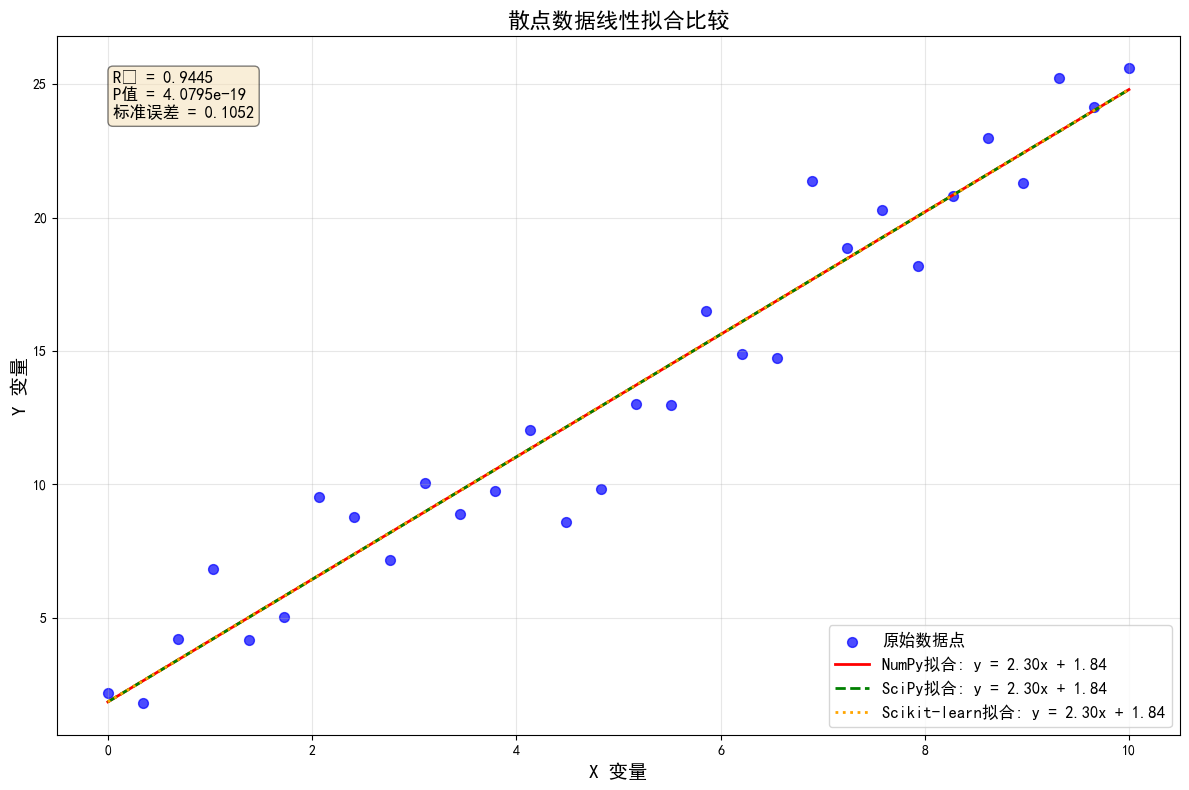

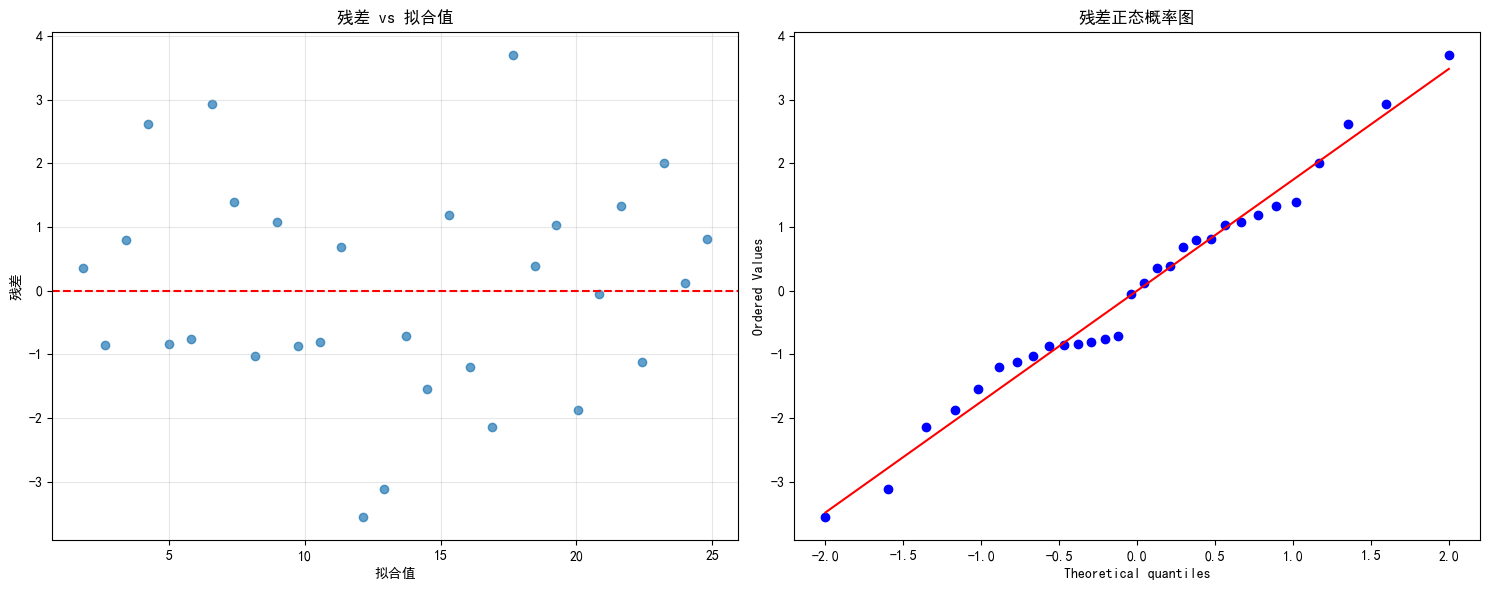


预测新数据点:
x = 2.5, 预测 y = 7.58
x = 5.0, 预测 y = 13.32
x = 7.5, 预测 y = 19.06
x = 10.5, 预测 y = 25.95

计算置信区间:
x = 2.5: 预测值 = 7.58, 95%置信区间 = [7.53, 7.63]
x = 5.0: 预测值 = 13.32, 95%置信区间 = [13.28, 13.36]
x = 7.5: 预测值 = 19.06, 95%置信区间 = [19.01, 19.12]
x = 10.5: 预测值 = 25.95, 95%置信区间 = [25.87, 26.04]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 生成示例数据
np.random.seed(42)  # 设置随机种子以确保结果可重现
x = np.linspace(0, 10, 30)
y = 2.5 * x + 1.2 + np.random.normal(0, 2, 30)  # 添加一些随机噪声

# 方法1: 使用NumPy的polyfit进行线性拟合
print("方法1: 使用NumPy的polyfit进行线性拟合")
coefficients = np.polyfit(x, y, 1)  # 1表示线性拟合
slope_np = coefficients[0]
intercept_np = coefficients[1]
print(f"斜率: {slope_np:.4f}")
print(f"截距: {intercept_np:.4f}")

# 创建拟合线
poly_func = np.poly1d(coefficients)
y_fit_np = poly_func(x)

# 方法2: 使用SciPy的linregress进行线性拟合
print("\n方法2: 使用SciPy的linregress进行线性拟合")
slope_scipy, intercept_scipy, r_value, p_value, std_err = stats.linregress(x, y)
print(f"斜率: {slope_scipy:.4f}")
print(f"截距: {intercept_scipy:.4f}")
print(f"R值(相关系数): {r_value:.4f}")
print(f"R平方: {r_value**2:.4f}")
print(f"P值: {p_value:.4f}")
print(f"标准误差: {std_err:.4f}")

# 创建拟合线
y_fit_scipy = slope_scipy * x + intercept_scipy

# 方法3: 使用Scikit-learn进行线性拟合
print("\n方法3: 使用Scikit-learn进行线性拟合")
# 将x转换为二维数组（sklearn要求特征矩阵是二维的）
x_reshaped = x.reshape(-1, 1)
model = LinearRegression()
model.fit(x_reshaped, y)
slope_sklearn = model.coef_[0]
intercept_sklearn = model.intercept_
print(f"斜率: {slope_sklearn:.4f}")
print(f"截距: {intercept_sklearn:.4f}")
print(f"R平方: {model.score(x_reshaped, y):.4f}")

# 创建拟合线
y_fit_sklearn = model.predict(x_reshaped)

# 可视化结果
plt.figure(figsize=(12, 8))

# 绘制原始数据点
plt.scatter(x, y, color='blue', alpha=0.7, label='原始数据点', s=50)

# 绘制三种方法的拟合线
plt.plot(x, y_fit_np, color='red', linewidth=2, label=f'NumPy拟合: y = {slope_np:.2f}x + {intercept_np:.2f}')
plt.plot(x, y_fit_scipy, color='green', linestyle='--', linewidth=2, 
         label=f'SciPy拟合: y = {slope_scipy:.2f}x + {intercept_scipy:.2f}')
plt.plot(x, y_fit_sklearn, color='orange', linestyle=':', linewidth=2, 
         label=f'Scikit-learn拟合: y = {slope_sklearn:.2f}x + {intercept_sklearn:.2f}')

# 添加图例、标题和标签
plt.legend(fontsize=12)
plt.title('散点数据线性拟合比较', fontsize=16)
plt.xlabel('X 变量', fontsize=14)
plt.ylabel('Y 变量', fontsize=14)
plt.grid(True, alpha=0.3)

# 添加拟合统计信息
textstr = f'R² = {r_value**2:.4f}\nP值 = {p_value:.4e}\n标准误差 = {std_err:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

# 残差分析
residuals = y - y_fit_scipy

# 创建残差图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 残差与拟合值的关系
ax1.scatter(y_fit_scipy, residuals, alpha=0.7)
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_xlabel('拟合值')
ax1.set_ylabel('残差')
ax1.set_title('残差 vs 拟合值')
ax1.grid(True, alpha=0.3)

# 残差的正态概率图
stats.probplot(residuals, dist="norm", plot=ax2)
ax2.set_title('残差正态概率图')

plt.tight_layout()
plt.show()

# 预测新数据点
print("\n预测新数据点:")
new_x = np.array([2.5, 5.0, 7.5, 10.5])
new_x_reshaped = new_x.reshape(-1, 1)
predictions = model.predict(new_x_reshaped)

for i, (x_val, y_val) in enumerate(zip(new_x, predictions)):
    print(f"x = {x_val:.1f}, 预测 y = {y_val:.2f}")

# 计算置信区间
print("\n计算置信区间:")
# 使用SciPy的方法计算置信区间
# 首先计算预测标准误差
n = len(x)
x_mean = np.mean(x)
t_value = stats.t.ppf(0.975, n-2)  # 95%置信区间，t分布临界值

# 对于每个新点计算置信区间
for i, x_val in enumerate(new_x):
    y_pred = slope_scipy * x_val + intercept_scipy
    se = std_err * np.sqrt(1/n + (x_val - x_mean)**2 / np.sum((x - x_mean)**2))
    ci_lower = y_pred - t_value * se
    ci_upper = y_pred + t_value * se
    print(f"x = {x_val:.1f}: 预测值 = {y_pred:.2f}, 95%置信区间 = [{ci_lower:.2f}, {ci_upper:.2f}]")\
        

解法一（圆台累加）体积: 4698775.412
解法二（数值积分）体积: 11202237.336
两种方法相对误差: 1.38e+00


f:\JupyterNotebook\Company\.v\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\JupyterNotebook\Company\.v\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\JupyterNotebook\Company\.v\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26059 (\N{CJK UNIFIED IDEOGRAPH-65CB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\JupyterNotebook\Company\.v\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36716 (\N{CJK UNIFIED IDEOGRAPH-8F6C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\JupyterNotebook\Company\.v\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missin

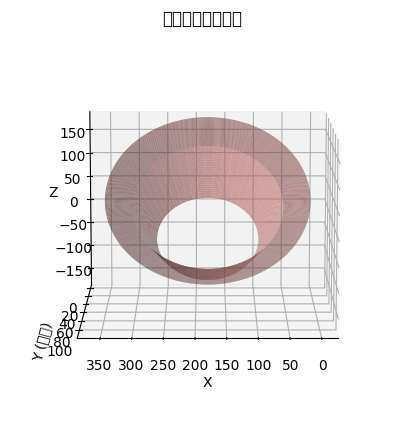

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ----------------- 解法一：圆台体积公式 -----------------
def frustum_volume(points):
    points = np.array(points)
    x_min, x_max = np.min(points[:,0]), np.max(points[:,0])
    center = (x_min + x_max) / 2
    radii = np.abs(points[:,0] - center)
    heights = points[:,1]

    total_volume = 0.0
    for i in range(len(points)-1):
        h = heights[i+1] - heights[i]
        if h <= 0:
            continue
        R1, R2 = radii[i], radii[i+1]
        V = np.pi * h * (R1**2 + R1*R2 + R2**2) / 3.0
        total_volume += V

    return total_volume, radii, heights, center

# ----------------- 解法二：积分法 (数值积分) -----------------
def volume_integral(points, n_samples=2000):
    points = np.array(points)
    x_min, x_max = np.min(points[:,0]), np.max(points[:,0])
    center = (x_min + x_max) / 2

    # 线性插值函数，y -> 半径
    def radius(y):
        xs, ys = points[:,0], points[:,1]
        radii = np.abs(xs - center)
        return np.interp(y, ys, radii)

    y_min, y_max = np.min(points[:,1]), np.max(points[:,1])
    Y = np.linspace(y_min, y_max, n_samples)
    R = radius(Y)
    dY = (y_max - y_min) / (n_samples - 1)
    V = np.sum(np.pi * R**2 * dY)
    return V

# 示例：6个转折点
points = [(0,0), (50,20), (100,110), (140,110), (150,30), (360,0)]

V1, radii, heights, center = frustum_volume(points)
V2 = volume_integral(points)

print(f"解法一（圆台累加）体积: {V1:.3f}")
print(f"解法二（数值积分）体积: {V2:.3f}")
print(f"两种方法相对误差: {abs(V1-V2)/V1:.2e}")

# ----------------- 三维绘制：侧视图 -----------------
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')

phi = np.linspace(0, 2*np.pi, 100)
for i in range(len(points)-1):
    y1, y2 = heights[i], heights[i+1]
    if y2 <= y1:
        continue
    R1, R2 = radii[i], radii[i+1]
    Y = np.linspace(y1, y2, 30)
    R = np.linspace(R1, R2, 30)
    Y, Phi = np.meshgrid(Y, phi)
    R, _ = np.meshgrid(R, phi)

    X = (R * np.cos(Phi)) + center
    Z = R * np.sin(Phi)
    ax.plot_surface(X, Y, Z, color='lightcoral', alpha=0.6, linewidth=0)

ax.view_init(elev=10, azim=90)  # 侧视图
ax.set_xlabel('X')
ax.set_ylabel('Y (高度)')
ax.set_zlabel('Z')
ax.set_title('旋转体三维侧视图')
plt.show()

C:\Users\Michael\AppData\Local\Temp\ipykernel_16468\926503261.py:169: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Vnum = np.trapz(np.pi * Rs**2, Ys)
C:\Users\Michael\AppData\Local\Temp\ipykernel_16468\926503261.py:221: UserWarning: Glyph 20391 (\N{CJK UNIFIED IDEOGRAPH-4FA7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_16468\926503261.py:221: UserWarning: Glyph 35270 (\N{CJK UNIFIED IDEOGRAPH-89C6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_16468\926503261.py:221: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\ipykernel_16468\926503261.py:221: UserWarning: Glyph 25240 (\N{CJK UNIFIED IDEOGRAPH-6298}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Michael\AppData\Local\Temp\

解析（基于 y 划分）体积 V = 1590838.524371965
数值积分（trapz）体积 V = 1590838.539568461
相对误差 = 9.553e-09


f:\JupyterNotebook\Company\.v\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20391 (\N{CJK UNIFIED IDEOGRAPH-4FA7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\JupyterNotebook\Company\.v\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35270 (\N{CJK UNIFIED IDEOGRAPH-89C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\JupyterNotebook\Company\.v\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\JupyterNotebook\Company\.v\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25240 (\N{CJK UNIFIED IDEOGRAPH-6298}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
f:\JupyterNotebook\Company\.v\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font

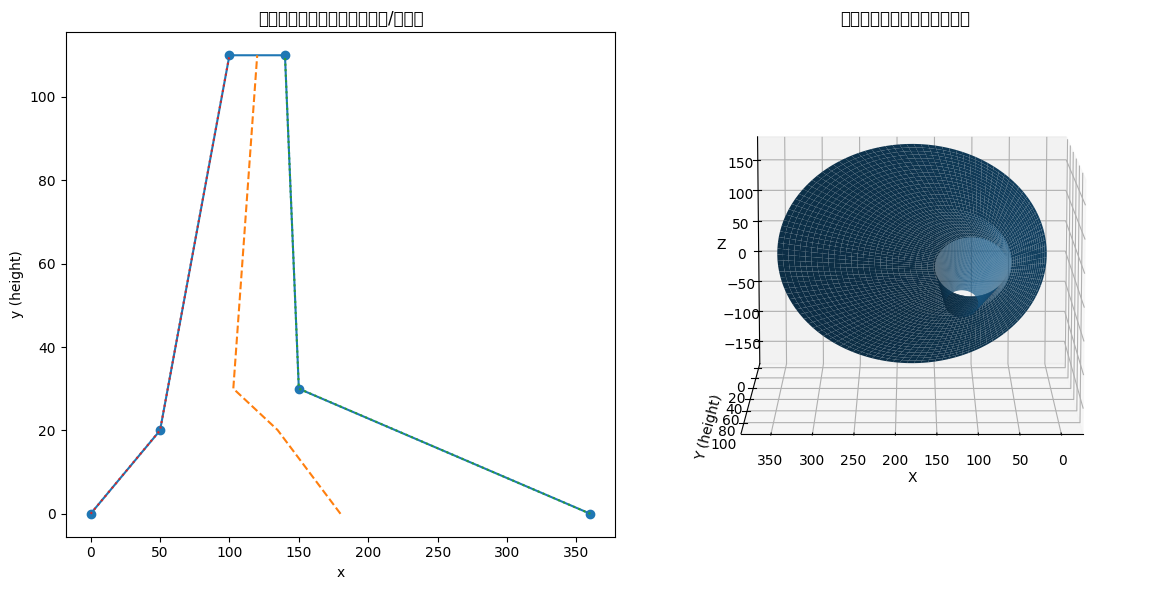

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ------------------------------------------------------------------
# 通用稳健实现（不再假设固定轴）
# 思路：
# 1) 对每个高度 y，求与折线各段的交点 x(y)，取最左和最右的交点 x_L(y), x_R(y)。
# 2) 将该水平线段绕其中点旋转，半径 r(y)=(x_R-x_L)/2，体积微元 dV = pi * r(y)^2 dy。
# 3) 为获得解析精确解，需要将 y 轴划分为若干区间，使得在每个区间内 x_L(y) 和 x_R(y)
#    都由单条线性段给出（线性函数），于是 r(y) 在该区间为线性函数，r^2 为二次多项式，能解析积分。
# 4) 为安全起见：我们把划分点设为所有顶点的 y 值 + 所有两条线性 x(y) 交点的 y 值（若在两段的公共 y 范围内）。
# ------------------------------------------------------------------


def analytic_volume_by_y(points):
    pts = np.array(points, dtype=float)
    # build segments as (x0,y0)->(x1,y1)
    segs = []
    for i in range(len(pts)-1):
        x0,y0 = pts[i]; x1,y1 = pts[i+1]
        # skip zero-length segments in x-y
        segs.append({'x0':x0,'y0':y0,'x1':x1,'y1':y1})

    # For a segment with y0 != y1, x(y) = a*y + b where a = (x1-x0)/(y1-y0), b = x0 - a*y0
    def linear_coeff(seg):
        if seg['y1'] == seg['y0']:
            return None  # horizontal segment: x(y) not a function (it's interval)
        a = (seg['x1'] - seg['x0']) / (seg['y1'] - seg['y0'])
        b = seg['x0'] - a * seg['y0']
        return a,b

    # collect candidate y cut points: all vertex y's
    y_cuts = list(np.unique(pts[:,1]))

    # add pairwise intersections y where x_i(y) == x_j(y)
    n = len(segs)
    for i in range(n):
        ci = linear_coeff(segs[i])
        if ci is None: continue
        ai,bi = ci
        yi_min, yi_max = min(segs[i]['y0'], segs[i]['y1']), max(segs[i]['y0'], segs[i]['y1'])
        for j in range(i+1,n):
            cj = linear_coeff(segs[j])
            if cj is None: continue
            aj,bj = cj
            # solve ai*y+bi = aj*y + bj -> y = (bj - bi)/(ai - aj) if ai != aj
            if abs(ai - aj) < 1e-12:
                continue
            y_int = (bj - bi) / (ai - aj)
            # include only if within both segments' y ranges
            yj_min, yj_max = min(segs[j]['y0'], segs[j]['y1']), max(segs[j]['y0'], segs[j]['y1'])
            if (y_int > max(yi_min, yj_min) - 1e-12) and (y_int < min(yi_max, yj_max) + 1e-12):
                y_cuts.append(y_int)

    # ensure sorted unique
    y_cuts = np.array(sorted(set([float(round(y,12)) for y in y_cuts])))

    # Now integrate over each small interval [ya, yb]
    def xvals_at_y(y):
        xs = []
        for seg in segs:
            y0,y1 = seg['y0'], seg['y1']
            x0,x1 = seg['x0'], seg['x1']
            if abs(y1 - y0) < 1e-12:
                # horizontal segment: only intersects if y equals this y
                if abs(y - y0) < 1e-9:
                    xs.append(x0); xs.append(x1)
            else:
                if (y >= min(y0,y1)-1e-12) and (y <= max(y0,y1)+1e-12):
                    a = (x1-x0)/(y1-y0)
                    b = x0 - a*y0
                    xs.append(a*y + b)
        return xs

    total_I = 0.0  # integral of r(y)^2 dy
    breakdown = []
    for k in range(len(y_cuts)-1):
        ya, yb = y_cuts[k], y_cuts[k+1]
        if yb <= ya + 1e-15:
            continue
        ymid = 0.5*(ya+yb)
        xs_mid = xvals_at_y(ymid)
        if len(xs_mid) < 2:
            # no horizontal chord in this slab
            continue
        # find left and right segments at midpoint
        xs_mid = np.array(xs_mid)
        xL_mid = xs_mid.min(); xR_mid = xs_mid.max()

        # determine which segment produces xL and xR at midpoint by checking all segments
        segL = None; segR = None
        for seg in segs:
            y0,y1 = seg['y0'], seg['y1']
            if abs(y1-y0) < 1e-12:
                continue
            if (ymid >= min(y0,y1)-1e-12) and (ymid <= max(y0,y1)+1e-12):
                a = (seg['x1']-seg['x0'])/(seg['y1']-seg['y0'])
                b = seg['x0'] - a*seg['y0']
                x_here = a*ymid + b
                if abs(x_here - xL_mid) < 1e-6:
                    segL = (a,b)
                if abs(x_here - xR_mid) < 1e-6:
                    segR = (a,b)
        # fallback: if not found (due to horizontal segments), pick min/max of linear approximations
        if segL is None or segR is None:
            # compute linear coefficients for all segments intersecting slab and pick those matching min/max at ymid
            aL,bL,aR,bR = None,None,None,None
            cand = []
            for seg in segs:
                y0,y1 = seg['y0'], seg['y1']
                if abs(y1-y0) < 1e-12:
                    continue
                if (ymid >= min(y0,y1)-1e-12) and (ymid <= max(y0,y1)+1e-12):
                    a = (seg['x1']-seg['x0'])/(seg['y1']-seg['y0'])
                    b = seg['x0'] - a*seg['y0']
                    cand.append((a,b,a*ymid+b))
            cand = sorted(cand, key=lambda t: t[2])
            aL,bL = cand[0][0], cand[0][1]
            aR,bR = cand[-1][0], cand[-1][1]
            segL = (aL,bL); segR = (aR,bR)

        aL,bL = segL; aR,bR = segR
        # x_left(y) = aL*y + bL; x_right(y) = aR*y + bR
        # r(y) = 0.5*(xR - xL) = A*y + B
        A = 0.5*(aR - aL)
        B = 0.5*(bR - bL)
        # integrate r^2 = (A^2) y^2 + 2AB y + B^2
        I = (A*A)/3.0*(yb**3 - ya**3) + (A*B)*(yb**2 - ya**2) + (B*B)*(yb - ya)
        total_I += I
        breakdown.append({'ya':ya,'yb':yb,'A':A,'B':B,'I':I})

    V = np.pi * total_I
    return V, total_I, breakdown, y_cuts


# 数值验证（按 y 方向数值积分）
def numeric_volume_by_y(points, n=20001):
    pts = np.array(points, dtype=float)
    y_min, y_max = float(np.min(pts[:,1])), float(np.max(pts[:,1]))
    Ys = np.linspace(y_min, y_max, n)

    def x_intersections_at_y(y):
        xs = []
        for i in range(len(pts)-1):
            x0,y0 = pts[i]; x1,y1 = pts[i+1]
            if abs(y1-y0) < 1e-12:
                if abs(y - y0) < 1e-9:
                    xs.extend([x0,x1])
            else:
                if (y >= min(y0,y1)-1e-12) and (y <= max(y0,y1)+1e-12):
                    x = x0 + (x1-x0)*( (y - y0)/(y1-y0) )
                    xs.append(x)
        return xs

    Rs = np.zeros_like(Ys)
    centers = np.zeros_like(Ys)
    for idx,y in enumerate(Ys):
        xs = x_intersections_at_y(y)
        if len(xs) < 2:
            Rs[idx] = 0.0
            centers[idx] = 0.5*(np.min(pts[:,0]) + np.max(pts[:,0]))
        else:
            xL = min(xs); xR = max(xs)
            Rs[idx] = 0.5*(xR - xL)
            centers[idx] = 0.5*(xR + xL)
    dY = (y_max - y_min)/(n-1)
    Vnum = np.trapz(np.pi * Rs**2, Ys)
    return Vnum, Ys, Rs, centers


# ----------------- 示例运行 -----------------
if __name__ == '__main__':
    points = [(0,0),(50,20),(100,110),(140,110),(150,30),(360,0)]

    V_analytic, I_analytic, breakdown, y_cuts = analytic_volume_by_y(points)
    V_numeric, Ys, Rs, centers = numeric_volume_by_y(points, n=20001)

    print(f"解析（基于 y 划分）体积 V = {V_analytic:.9f}")
    print(f"数值积分（trapz）体积 V = {V_numeric:.9f}")
    print(f"相对误差 = {abs(V_analytic - V_numeric)/max(abs(V_analytic),1e-16):.3e}")

    # 生成分段积分明细表格并显示
    df = pd.DataFrame(breakdown)
    if not df.empty:
        df['volume'] = np.pi * df['I']
    
    # 绘图：侧视图（沿 x-y 平面看）和三维旋转体（侧视）
    fig = plt.figure(figsize=(12,6))

    # 1) 侧视：画出折线和半径随 y 的变化（中心线 + 半径）
    ax1 = fig.add_subplot(1,2,1)
    pts = np.array(points)
    ax1.plot(pts[:,0], pts[:,1], marker='o')
    # plot center curve and radius envelope
    ax1.plot(centers, Ys, linestyle='--')
    ax1.plot(centers + Rs, Ys, linestyle=':')
    ax1.plot(centers - Rs, Ys, linestyle=':')
    ax1.set_xlabel('x'); ax1.set_ylabel('y (height)'); ax1.set_title('侧视：折线与水平截面（中心/边界）')

    # 2) 3D 侧视旋转体：为每个 y 旋转出圆
    ax2 = fig.add_subplot(1,2,2, projection='3d')
    theta = np.linspace(0, 2*np.pi, 120)
    Y_grid, Theta = np.meshgrid(Ys[::200], theta)  # 取稀疏的 y 样点用于绘图
    R_grid = np.interp(Y_grid[0,:], Ys, Rs)
    # build mesh: for plotting we want matrices with shape (theta, y)
    R_full = np.tile(R_grid, (theta.size,1))
    Center_grid = np.interp(Y_grid[0,:], Ys, centers)
    Center_full = np.tile(Center_grid, (theta.size,1))

    X = Center_full + R_full * np.cos(Theta)
    Z = R_full * np.sin(Theta)
    Y_plot = np.tile(Y_grid[0,:], (theta.size,1))

    ax2.plot_surface(X, Y_plot, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
    ax2.view_init(elev=10, azim=90)  # 侧视
    ax2.set_xlabel('X'); ax2.set_ylabel('Y (height)'); ax2.set_zlabel('Z')
    ax2.set_title('旋转体三维侧视（近似示意）')

    plt.tight_layout()
    plt.show()

    # 返回计算明细表格
    try:
        from caas_jupyter_tools import display_dataframe_to_user
        if not df.empty:
            display_dataframe_to_user('per_interval_breakdown', df)
    except Exception:
        pass



In [2]:
# Fix and re-run the plotting & animation code (escaped strings corrected).
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import os
from scipy.integrate import trapezoid

def analytic_volume_by_y(points):
    pts = np.array(points, dtype=float)
    segs = []
    for i in range(len(pts)-1):
        x0,y0 = pts[i]; x1,y1 = pts[i+1]
        segs.append({'x0':x0,'y0':y0,'x1':x1,'y1':y1})

    def linear_coeff(seg):
        if abs(seg['y1'] - seg['y0']) < 1e-15:
            return None
        a = (seg['x1'] - seg['x0']) / (seg['y1'] - seg['y0'])
        b = seg['x0'] - a * seg['y0']
        return a,b

    y_cuts = list(np.unique(pts[:,1]))
    n = len(segs)
    for i in range(n):
        ci = linear_coeff(segs[i])
        if ci is None: continue
        ai,bi = ci
        yi_min, yi_max = min(segs[i]['y0'], segs[i]['y1']), max(segs[i]['y0'], segs[i]['y1'])
        for j in range(i+1,n):
            cj = linear_coeff(segs[j])
            if cj is None: continue
            aj,bj = cj
            if abs(ai - aj) < 1e-12:
                continue
            y_int = (bj - bi) / (ai - aj)
            yj_min, yj_max = min(segs[j]['y0'], segs[j]['y1']), max(segs[j]['y0'], segs[j]['y1'])
            if (y_int > max(yi_min, yj_min) - 1e-12) and (y_int < min(yi_max, yj_max) + 1e-12):
                y_cuts.append(y_int)

    y_cuts = np.array(sorted(set([float(round(y,12)) for y in y_cuts])))

    def xvals_at_y(y):
        xs = []
        for seg in segs:
            y0,y1 = seg['y0'], seg['y1']
            x0,x1 = seg['x0'], seg['x1']
            if abs(y1 - y0) < 1e-12:
                if abs(y - y0) < 1e-9:
                    xs.append(x0); xs.append(x1)
            else:
                if (y >= min(y0,y1)-1e-12) and (y <= max(y0,y1)+1e-12):
                    a = (x1-x0)/(y1-y0)
                    b = x0 - a*y0
                    xs.append(a*y + b)
        return xs

    total_I = 0.0
    breakdown = []
    for k in range(len(y_cuts)-1):
        ya, yb = y_cuts[k], y_cuts[k+1]
        if yb <= ya + 1e-15:
            continue
        ymid = 0.5*(ya+yb)
        xs_mid = xvals_at_y(ymid)
        if len(xs_mid) < 2:
            continue
        xs_mid = np.array(xs_mid)
        xL_mid = xs_mid.min(); xR_mid = xs_mid.max()

        segL = None; segR = None
        for seg in segs:
            y0,y1 = seg['y0'], seg['y1']
            if abs(y1-y0) < 1e-12:
                continue
            if (ymid >= min(y0,y1)-1e-12) and (ymid <= max(y0,y1)+1e-12):
                a = (seg['x1']-seg['x0'])/(seg['y1']-seg['y0'])
                b = seg['x0'] - a*seg['y0']
                x_here = a*ymid + b
                if abs(x_here - xL_mid) < 1e-6:
                    segL = (a,b)
                if abs(x_here - xR_mid) < 1e-6:
                    segR = (a,b)
        if segL is None or segR is None:
            cand = []
            for seg in segs:
                y0,y1 = seg['y0'], seg['y1']
                if abs(y1-y0) < 1e-12:
                    continue
                if (ymid >= min(y0,y1)-1e-12) and (ymid <= max(y0,y1)+1e-12):
                    a = (seg['x1']-seg['x0'])/(seg['y1']-seg['y0'])
                    b = seg['x0'] - a*seg['y0']
                    cand.append((a,b,a*ymid+b))
            cand = sorted(cand, key=lambda t: t[2])
            aL,bL = cand[0][0], cand[0][1]
            aR,bR = cand[-1][0], cand[-1][1]
            segL = (aL,bL); segR = (aR,bR)

        aL,bL = segL; aR,bR = segR
        A = 0.5*(aR - aL)
        B = 0.5*(bR - bL)
        I = (A*A)/3.0*(yb**3 - ya**3) + (A*B)*(yb**2 - ya**2) + (B*B)*(yb - ya)
        total_I += I
        breakdown.append({'ya':ya,'yb':yb,'A':A,'B':B,'I':I})

    V = np.pi * total_I
    return V, total_I, breakdown, y_cuts

def numeric_volume_by_y(points, n=5001):
    pts = np.array(points, dtype=float)
    y_min, y_max = float(np.min(pts[:,1])), float(np.max(pts[:,1]))
    Ys = np.linspace(y_min, y_max, n)

    def x_intersections_at_y(y):
        xs = []
        for i in range(len(pts)-1):
            x0,y0 = pts[i]; x1,y1 = pts[i+1]
            if abs(y1-y0) < 1e-12:
                if abs(y - y0) < 1e-9:
                    xs.extend([x0,x1])
            else:
                if (y >= min(y0,y1)-1e-12) and (y <= max(y0,y1)+1e-12):
                    x = x0 + (x1-x0)*( (y - y0)/(y1-y0) )
                    xs.append(x)
        return xs

    Rs = np.zeros_like(Ys)
    centers = np.zeros_like(Ys)
    for idx,y in enumerate(Ys):
        xs = x_intersections_at_y(y)
        if len(xs) < 2:
            Rs[idx] = 0.0
            centers[idx] = 0.5*(np.min(pts[:,0]) + np.max(pts[:,0]))
        else:
            xL = min(xs); xR = max(xs)
            Rs[idx] = 0.5*(xR - xL)
            centers[idx] = 0.5*(xR + xL)
    Vnum = trapezoid(np.pi * Rs**2, Ys)
    return Vnum, Ys, Rs, centers


In [ ]:

# --- user's points ---
points = [(0,0),(50,20),(100,110),(140,110),(150,30),(360,0)]

V_analytic, I_analytic, breakdown, y_cuts = analytic_volume_by_y(points)
V_numeric, Ys, Rs, centers = numeric_volume_by_y(points, n=5001)

print("解析（基于 y 划分）体积 V = {:.9f}".format(V_analytic))
print("数值积分（trapz）体积 V = {:.9f}".format(V_numeric))
print("相对误差 = {:.3e}".format(abs(V_analytic - V_numeric)/max(abs(V_analytic),1e-16)))

# --- prepare mesh for plotting (sparser for visuals) ---
theta = np.linspace(0, 2*np.pi, 160)
Y_plot = Ys[::200]
R_plot = np.interp(Y_plot, Ys, Rs)
C_plot = np.interp(Y_plot, Ys, centers)
Theta, Y_mesh = np.meshgrid(theta, Y_plot, indexing='ij')
R_mesh = np.tile(R_plot, (theta.size,1))
C_mesh = np.tile(C_plot, (theta.size,1))

X = C_mesh + R_mesh * np.cos(Theta)
Z = R_mesh * np.sin(Theta)
Yp = Y_mesh

# --- 3 views: top, oblique, side ---
out_files = []

# Top view (looking down along +Y axis): elev=90
fig1 = plt.figure(figsize=(6,6))
ax1 = fig1.add_subplot(111, projection='3d')
ax1.plot_surface(X, Yp, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
ax1.view_init(elev=90, azim=-90)  # top-down
ax1.set_title('Top view (looking down)')
ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
f1 = 'top_view.png'
fig1.savefig(f1, dpi =600)
out_files.append(f1)
plt.close(fig1)

# Oblique view (e.g., elev=30, azim=45)
fig2 = plt.figure(figsize=(7,6))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.plot_surface(X, Yp, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
ax2.view_init(elev=30, azim=45)
ax2.set_title('Oblique view (elev=30, azim=45)')
ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
f2 = 'oblique_view.png'
fig2.savefig(f2, dpi =600)
out_files.append(f2)
plt.close(fig2)

# Side view (same as previous side)
fig3 = plt.figure(figsize=(7,6))
ax3 = fig3.add_subplot(111, projection='3d')
ax3.plot_surface(X, Yp, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
ax3.view_init(elev=10, azim=90)
ax3.set_title('Side view (elev=10, azim=90)')
ax3.set_xlabel('X'); ax3.set_ylabel('Y'); ax3.set_zlabel('Z')
f3 = 'side_view.png'
fig3.savefig(f3, dpi =600)
out_files.append(f3)
plt.close(fig3)

# --- Animation: rotating azim 0->360, save as GIF ---
fig_anim = plt.figure(figsize=(6,6))
ax_anim = fig_anim.add_subplot(111, projection='3d')

def update(frame):
    ax_anim.clear()
    ax_anim.plot_surface(X, Yp, Z, rstride=1, cstride=1, linewidth=0, antialiased=True)
    az = frame
    ax_anim.view_init(elev=20, azim=az)
    ax_anim.set_axis_off()
    return []

frames = list(range(0,360,6))  # 60 frames
anim = animation.FuncAnimation(fig_anim, update, frames=frames, blit=False)
gif_path = 'rotation.gif'
# try PillowWriter
try:
    writer = animation.PillowWriter(fps=12)
    anim.save(gif_path, writer=writer)
    out_files.append(gif_path)
    plt.close(fig_anim)
except Exception as e:
    print('Failed to save GIF with PillowWriter:', e)
    try:
        mp4_path = 'rotation.mp4'
        writer = animation.FFMpegWriter(fps=12)
        anim.save(mp4_path, writer=writer)
        out_files.append(mp4_path)
        plt.close(fig_anim)
    except Exception as e2:
        print('Failed to save mp4:', e2)
        plt.close(fig_anim)

# List generated files
print('Generated files:')
for p in out_files:
    print(p)

results = {
    "V_analytic": V_analytic,
    "V_numeric": V_numeric,
    "rel_err": abs(V_analytic - V_numeric)/max(abs(V_analytic),1e-16),
    "files": out_files
}
results


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib.colors import LightSource
from scipy.integrate import trapezoid

# -----------------------------
# 解析和数值体积计算函数
# -----------------------------
def analytic_volume_by_y(points):
    pts = np.array(points, dtype=float)
    segs = []
    for i in range(len(pts)-1):
        x0,y0 = pts[i]; x1,y1 = pts[i+1]
        segs.append({'x0':x0,'y0':y0,'x1':x1,'y1':y1})

    def linear_coeff(seg):
        if abs(seg['y1'] - seg['y0']) < 1e-15: return None
        a = (seg['x1'] - seg['x0']) / (seg['y1'] - seg['y0'])
        b = seg['x0'] - a*seg['y0']
        return a,b

    y_cuts = list(np.unique(pts[:,1]))
    n = len(segs)
    for i in range(n):
        ci = linear_coeff(segs[i])
        if ci is None: continue
        ai,bi = ci
        yi_min, yi_max = min(segs[i]['y0'], segs[i]['y1']), max(segs[i]['y0'], segs[i]['y1'])
        for j in range(i+1,n):
            cj = linear_coeff(segs[j])
            if cj is None: continue
            aj,bj = cj
            if abs(ai-aj) < 1e-12: continue
            y_int = (bj - bi)/(ai - aj)
            yj_min, yj_max = min(segs[j]['y0'], segs[j]['y1']), max(segs[j]['y0'], segs[j]['y1'])
            if (y_int > max(yi_min, yj_min)-1e-12) and (y_int < min(yi_max, yj_max)+1e-12):
                y_cuts.append(y_int)

    y_cuts = np.array(sorted(set([float(round(y,12)) for y in y_cuts])))

    def xvals_at_y(y):
        xs = []
        for seg in segs:
            y0,y1 = seg['y0'], seg['y1']
            x0,x1 = seg['x0'], seg['x1']
            if abs(y1 - y0) < 1e-12:
                if abs(y - y0) < 1e-9: xs.extend([x0,x1])
            else:
                if (y >= min(y0,y1)-1e-12) and (y <= max(y0,y1)+1e-12):
                    a = (x1-x0)/(y1-y0)
                    b = x0 - a*y0
                    xs.append(a*y + b)
        return xs

    total_I = 0.0
    breakdown = []
    for k in range(len(y_cuts)-1):
        ya, yb = y_cuts[k], y_cuts[k+1]
        if yb <= ya + 1e-15: continue
        ymid = 0.5*(ya+yb)
        xs_mid = xvals_at_y(ymid)
        if len(xs_mid) < 2: continue
        xs_mid = np.array(xs_mid)
        xL_mid = xs_mid.min(); xR_mid = xs_mid.max()
        segL, segR = None, None
        for seg in segs:
            y0,y1 = seg['y0'], seg['y1']
            if abs(y1-y0) < 1e-12: continue
            if (ymid >= min(y0,y1)-1e-12) and (ymid <= max(y0,y1)+1e-12):
                a = (seg['x1']-seg['x0'])/(seg['y1']-seg['y0'])
                b = seg['x0'] - a*seg['y0']
                x_here = a*ymid + b
                if abs(x_here - xL_mid) < 1e-6: segL=(a,b)
                if abs(x_here - xR_mid) < 1e-6: segR=(a,b)
        if segL is None or segR is None:
            cand = []
            for seg in segs:
                y0,y1 = seg['y0'], seg['y1']
                if abs(y1-y0)<1e-12: continue
                if (ymid >= min(y0,y1)-1e-12) and (ymid <= max(y0,y1)+1e-12):
                    a=(seg['x1']-seg['x0'])/(seg['y1']-seg['y0'])
                    b=seg['x0']-a*seg['y0']
                    cand.append((a,b,a*ymid+b))
            cand = sorted(cand,key=lambda t:t[2])
            aL,bL=cand[0][0],cand[0][1]; aR,bR=cand[-1][0],cand[-1][1]
            segL,segR=(aL,bL),(aR,bR)
        aL,bL=segL; aR,bR=segR
        A=0.5*(aR-aL); B=0.5*(bR-bL)
        I=(A*A)/3*(yb**3-ya**3)+(A*B)*(yb**2-ya**2)+(B*B)*(yb-ya)
        total_I+=I
        breakdown.append({'ya':ya,'yb':yb,'A':A,'B':B,'I':I})
    V=np.pi*total_I
    return V,total_I,breakdown,y_cuts

def numeric_volume_by_y(points, n=5001):
    pts = np.array(points, dtype=float)
    y_min, y_max = float(np.min(pts[:,1])), float(np.max(pts[:,1]))
    Ys = np.linspace(y_min,y_max,n)

    def x_intersections_at_y(y):
        xs=[]
        for i in range(len(pts)-1):
            x0,y0 = pts[i]; x1,y1 = pts[i+1]
            if abs(y1-y0)<1e-12:
                if abs(y-y0)<1e-9: xs.extend([x0,x1])
            else:
                if (y>=min(y0,y1)-1e-12) and (y<=max(y0,y1)+1e-12):
                    xs.append(x0+(x1-x0)*( (y-y0)/(y1-y0)))
        return xs

    Rs = np.zeros_like(Ys)
    centers = np.zeros_like(Ys)
    for idx,y in enumerate(Ys):
        xs = x_intersections_at_y(y)
        if len(xs)<2:
            Rs[idx]=0.0
            centers[idx]=0.5*(np.min(pts[:,0])+np.max(pts[:,0]))
        else:
            xL=min(xs); xR=max(xs)
            Rs[idx]=0.5*(xR-xL)
            centers[idx]=0.5*(xR+xL)
    Vnum = trapezoid(np.pi*Rs**2,Ys)
    return Vnum,Ys,Rs,centers

# -----------------------------
# 用户点
# -----------------------------
points = [(0,0),(50,20),(100,110),(140,110),(150,30),(360,0)]

V_analytic,I_analytic,breakdown,y_cuts = analytic_volume_by_y(points)
V_numeric,Ys,Rs,centers = numeric_volume_by_y(points, n=5001)
rel_err = abs(V_analytic - V_numeric)/max(abs(V_analytic),1e-16)

print(f"解析体积 V = {V_analytic:.9f}")
print(f"数值体积 V = {V_numeric:.9f}")
print(f"相对误差 = {rel_err:.3e}")

# -----------------------------
# Mesh for plotting
# -----------------------------
theta = np.linspace(0,2*np.pi,160)
Y_plot = Ys[::200]
R_plot = np.interp(Y_plot,Ys,Rs)
C_plot = np.interp(Y_plot,Ys,centers)
Theta,Y_mesh = np.meshgrid(theta,Y_plot,indexing='ij')
R_mesh = np.tile(R_plot,(theta.size,1))
C_mesh = np.tile(C_plot,(theta.size,1))

X = C_mesh + R_mesh*np.cos(Theta)
Z = R_mesh * np.sin(Theta)
Yp = Y_mesh

# 光照效果
ls = LightSource(azdeg=45, altdeg=60)
rgb = ls.shade(np.sqrt(X**2 + Z**2), cmap=plt.cm.viridis)

# -----------------------------
# 绘图函数
# -----------------------------

def add_cap_surface(ax, R, C, y_val, Nr=40, Ntheta=160):
    # 网格化圆盘封底/顶面
    r = np.linspace(0, R, Nr)
    theta = np.linspace(0, 2*np.pi, Ntheta)
    R_grid, Theta_grid = np.meshgrid(r, theta)
    Xc = C + R_grid * np.cos(Theta_grid)
    Zc = R_grid * np.sin(Theta_grid)
    Yc = np.full_like(Xc, y_val)
    ax.plot_surface(Xc, Yc, Zc, color='lightgray', alpha=0.6, linewidth=0, antialiased=False)

def plot_solid(ax, X, Yp, Z, R_plot, C_plot, Y_plot, rgb=None):
    # 主体
    ax.plot_surface(X, Yp, Z, facecolors=rgb, rstride=1, cstride=1, linewidth=0, antialiased=False)
    # 封底
    add_cap_surface(ax, R_plot[0], C_plot[0], Y_plot[0])
    # 封顶
    add_cap_surface(ax, R_plot[-1], C_plot[-1], Y_plot[-1])
    ax.set_axis_off()

# -----------------------------
# 生成静态视角 PNG
# -----------------------------
out_files = []
views = [
    (90, -90, "Top view"),
    (30, 45, "Oblique view"),
    (10, 90, "Side view")
]

for elev, azim, title in views:
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    plot_solid(ax, X, Yp, Z, R_plot, C_plot, Y_plot, rgb)
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(title)
    f = title.replace(" ","_") + ".png"
    fig.savefig(f, dpi =600)
    out_files.append(f)
    plt.close(fig)

# -----------------------------
# 动画 GIF
# -----------------------------
fig_anim = plt.figure(figsize=(6,6))
ax_anim = fig_anim.add_subplot(111, projection='3d')

def update(frame):
    ax_anim.clear()
    plot_solid(ax_anim, X, Yp, Z, R_plot, C_plot, Y_plot, rgb)
    ax_anim.view_init(elev=20, azim=frame)
    return []

frames = list(range(0,360,6))
anim = animation.FuncAnimation(fig_anim, update, frames=frames, blit=False)

gif_path = 'rotation.gif'
try:
    writer = animation.PillowWriter(fps=12)
    anim.save(gif_path, writer=writer)
    out_files.append(gif_path)
    plt.close(fig_anim)
except Exception as e:
    print("GIF保存失败:", e)
    plt.close(fig_anim)

# -----------------------------
# 输出结果
# -----------------------------
results = {
    "V_analytic": V_analytic,
    "V_numeric": V_numeric,
    "rel_err": rel_err,
    "files": out_files
}

print("生成文件:")
for p in out_files:
    print(p)

results


解析体积 V = 1590838.524371965
数值体积 V = 1590838.744745855
相对误差 = 1.385e-07
生成文件:
Top_view.png
Oblique_view.png
Side_view.png
rotation.gif


{'V_analytic': np.float64(1590838.5243719649),
 'V_numeric': np.float64(1590838.7447458545),
 'rel_err': np.float64(1.3852687515924207e-07),
 'files': ['Top_view.png',
  'Oblique_view.png',
  'Side_view.png',
  'rotation.gif']}